### 1. Data Understanding and Loading

In [1]:
# Importing the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Loading te data into the Notebook
dataset = pd.read_csv("data/dataset.csv")

dataset.head()

,CustomerID,ProductID,PurchaseDate,Quantity,Price,TotalAmount
0,103,58,2023-01-01 0:00,9,139.00,1251.00
1,436,23,2023-01-01 1:00,3,302.90,908.70
2,861,54,2023-01-01 2:00,1,465.33,465.33
3,271,80,2023-01-01 3:00,2,429.06,858.12
4,107,65,2023-01-01 4:00,6,232.89,1397.34


In [3]:
# Shape of the dataset
print(f"Shape of the dataset is: {dataset.shape}")

Shape of the dataset is: (10000, 6)


In [4]:
# Determine the number of non-null values of each feature and the data type 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CustomerID    10000 non-null  int64  
 1   ProductID     10000 non-null  int64  
 2   PurchaseDate  10000 non-null  object 
 3   Quantity      10000 non-null  int64  
 4   Price         10000 non-null  float64
 5   TotalAmount   10000 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


In [5]:
# Statistics for the numerical features of the data
dataset.describe()

,CustomerID,ProductID,Quantity,Price,TotalAmount
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,504.470600,50.734200,4.963900,252.576233,1254.981401
std,289.724434,28.768154,2.578616,142.067372,1027.526370
min,1.000000,1.000000,1.000000,5.020000,5.170000
25%,251.000000,26.000000,3.000000,131.145000,409.810000
50%,506.500000,51.000000,5.000000,253.420000,968.290000
75%,758.000000,76.000000,7.000000,373.882500,1895.370000
max,1000.000000,100.000000,9.000000,499.950000,4492.800000


In [6]:
# Statistics for no numerical features of the data
dataset.describe(include = "O")

,PurchaseDate
count,10000
unique,10000
top,2023-01-01 0:00
freq,1


### 2. Data Preprocessing

In [7]:
# Changing the data type of the column "PurchaseDate" from Object to Datetime
dataset["PurchaseDate"] = pd.to_datetime(dataset["PurchaseDate"])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CustomerID    10000 non-null  int64         
 1   ProductID     10000 non-null  int64         
 2   PurchaseDate  10000 non-null  datetime64[ns]
 3   Quantity      10000 non-null  int64         
 4   Price         10000 non-null  float64       
 5   TotalAmount   10000 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 468.9 KB


In [ ]:
# Splitting the PurchaseDate column into Year, Month, Day and Hour column
dataset["Year"] = dataset["PurchaseDate"].dt.year
dataset["Month"] = dataset["PurchaseDate"].dt.month
dataset["Day"] = dataset["PurchaseDate"].dt.day
dataset["Hour"] = dataset["PurchaseDate"].dt.hour

# Dropping the column "PurchaseDate"
dataset.drop("PurchaseDate", axis = 1, inplace = True)

dataset.head()

,CustomerID,ProductID,Quantity,Price,TotalAmount,Year,Month,Day,Hour
0,103,58,9,139.00,1251.00,2023,1,1,0
1,436,23,3,302.90,908.70,2023,1,1,1
2,861,54,1,465.33,465.33,2023,1,1,2
3,271,80,2,429.06,858.12,2023,1,1,3
4,107,65,6,232.89,1397.34,2023,1,1,4


In [9]:
# Changing the "Year", "Month", "Day", "Hour" into Object data type
cols = ["Year", "Month", "Day", "Hour"]

for col in cols:
    dataset[col] = dataset[col].astype("object")

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CustomerID   10000 non-null  int64  
 1   ProductID    10000 non-null  int64  
 2   Quantity     10000 non-null  int64  
 3   Price        10000 non-null  float64
 4   TotalAmount  10000 non-null  float64
 5   Year         10000 non-null  object 
 6   Month        10000 non-null  object 
 7   Day          10000 non-null  object 
 8   Hour         10000 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 703.3+ KB


In [11]:
# Function to return the count of outliers in each column
def iqr_val(col, threshold):

    # Taking the 75 and 25 percentile
    q3 = np.percentile(col, 75)
    q1 = np.percentile(col, 25)

    # Inter Quantile Range
    IQR = q3 - q1

    lower_bound = q1 - (IQR * threshold)
    upper_bound = q3 + (IQR * threshold)

    return lower_bound, upper_bound

# Function that will detect the outliers and remove if the parameter `remove_outliers` is set `True`
def detecting_outliers(data, remove_outliers = False, threshold = 1.5):

    # Initialising a dictionary that will hold the number of outliers
    outliers_count = {}
    new_data = data.copy()
    
    for col in new_data.columns:
        col_data = new_data[col].dropna()

        # If statement so that only the int or float columns are used
        if col_data.dtype in [np.int64, np.float64]:
            
            # Lower and Upper bound values
            lb, ub = iqr_val(col = col_data, threshold = threshold)
            outliers = np.where((col_data < lb) | (col_data > ub))[0]

            # Taking the count of the outliers
            outliers_count[col] = len(outliers)
            
            # If remove_outliers is set to `True` removing those values
            if remove_outliers:
                new_data = new_data[(new_data[col] >= lb) & (new_data[col] <= ub)]
    
    return new_data, outliers_count

In [ ]:
# Names of the column which are either "int64" or "float64"
data, outliers_count_per_col = detecting_outliers(dataset, remove_outliers = False)

print("Number of the outliers in each columns -")
for col, count in outliers_count_per_col.items():
    print(f"{col}: {count}")

Number of the outliers in each columns -
CustomerID: 0
ProductID: 0
Quantity: 0
Price: 0
TotalAmount: 93


### 3. Exploratory Data Analysis (EDA)

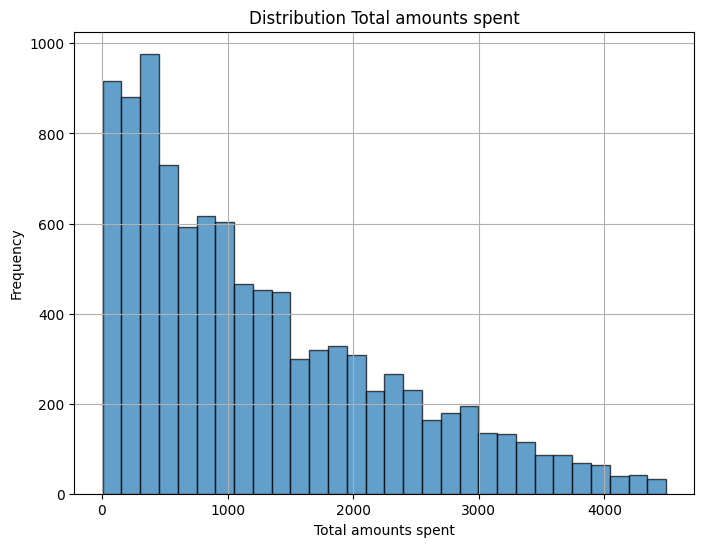

In [13]:
# Create a histogram distribution of total amounts spent
plt.figure(figsize = (8, 6))
plt.hist(dataset["TotalAmount"], bins = 30, edgecolor = "k", alpha = 0.7)
plt.title("Distribution Total amounts spent")
plt.xlabel("Total amounts spent")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

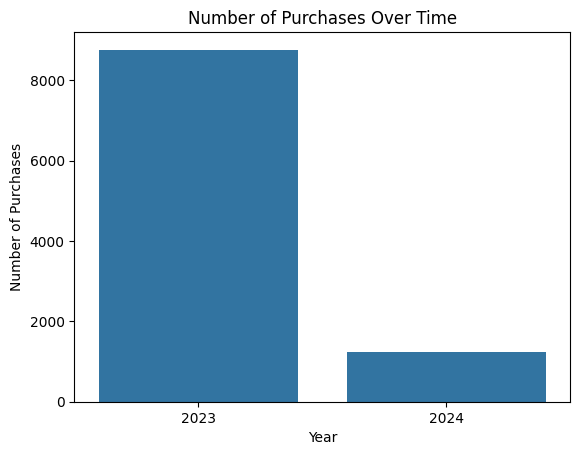

In [14]:
# Number of purchases per year
sns.countplot(x = "Year", data = dataset)
plt.title("Number of Purchases Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Purchases")
plt.show()

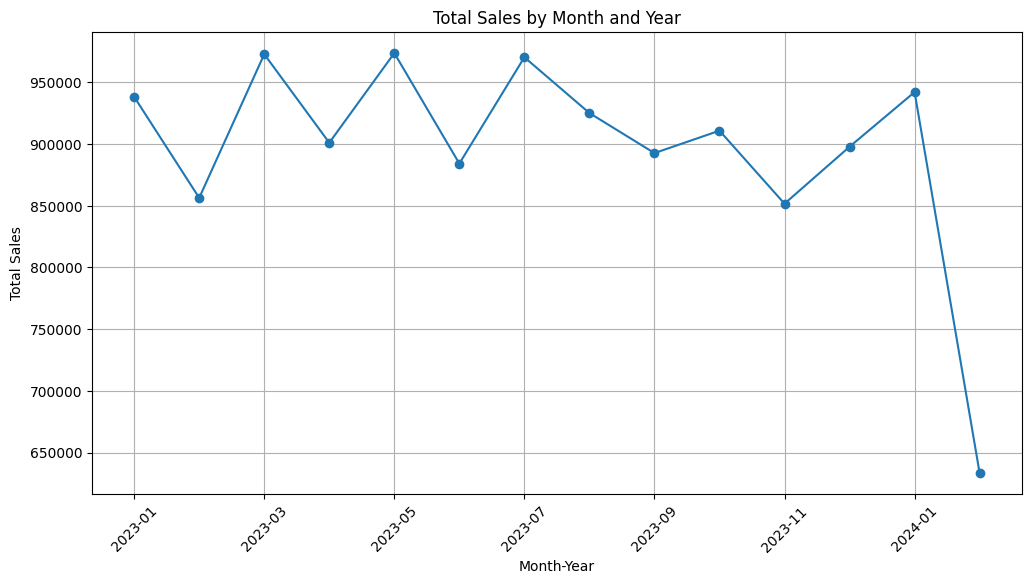

In [15]:
# Create a combined Year-Month column
dataset["YearMonth"] = dataset["Year"].astype(str) + "-" + dataset["Month"].astype(str).str.zfill(2)

# Group by YearMonth and sum
df_monthly_purchases = dataset.groupby("YearMonth").sum(numeric_only = True)

# Create graph
plt.figure(figsize = (12, 6))
df_monthly_purchases["TotalAmount"].plot(kind = "line", marker = "o", linestyle = "-")
plt.title("Total Sales by Month and Year")
plt.xlabel("Month-Year")
plt.ylabel("Total Sales")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


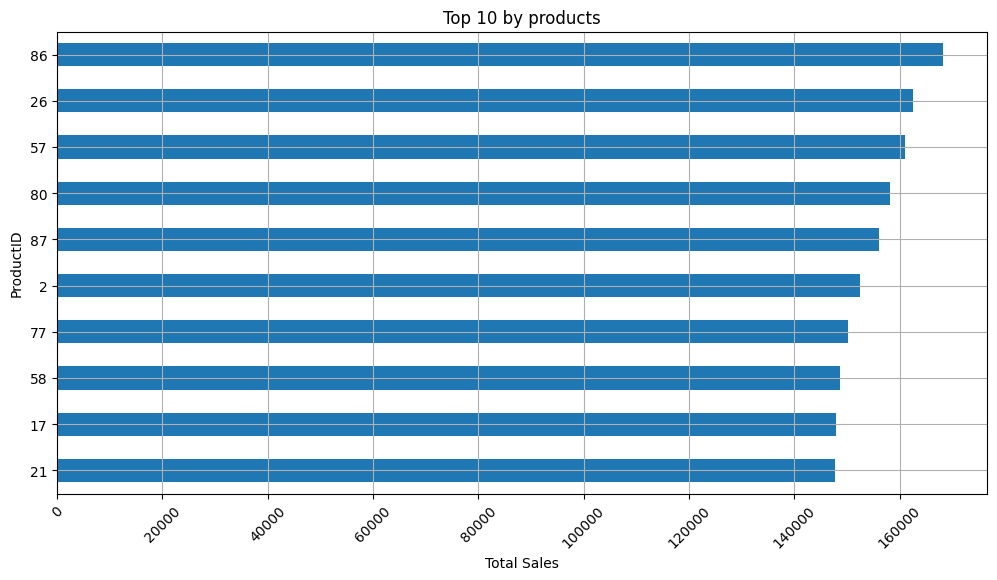

In [16]:
# Group by ProductID and sum
sales = dataset.groupby("ProductID")["TotalAmount"].sum()

# Sort products by total sales in descending order and select the top 10
top_10_products = sales.sort_values(ascending = False).head(10)

# Create bar chart
plt.figure(figsize = (12, 6))
top_10_products.plot(kind = "barh")
plt.title("Top 10 by products" )
plt.xlabel("Total Sales")
plt.ylabel("ProductID")
plt.gca().invert_yaxis()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


### 4. Analysis and Insights

In [17]:
customer_sales = dataset.groupby("CustomerID")["TotalAmount"].sum().reset_index()

# Sort the customers by TotalAmount in descending order to identify the most valuable customers
top_customers = customer_sales.sort_values(by = "TotalAmount", ascending=False).head(10)

print("Top 10 Most Valuable Customers")
print(top_customers)

Top 10 Most Valuable Customers
     CustomerID  TotalAmount
890         891     34629.43
476         477     31258.97
11           12     31164.61
112         113     30856.59
108         109     30560.29
725         726     30223.13
775         776     29415.56
987         988     29289.22
400         401     28584.98
793         794     28036.36


In [18]:
# Grouping data by CustomerID to get total quantity, total amount spent, and average price per customer
customer_stats = dataset.groupby("CustomerID").agg({
    "Quantity": "sum",
    "TotalAmount": "sum",
    "Price": "mean"
})
print(customer_stats.head())

            Quantity  TotalAmount       Price
CustomerID                                   
1                 70     17026.90  270.075625
2                 48      7928.46  231.430000
3                 52     14719.17  275.021111
4                 25      5148.99  166.250000
5                 33      9319.94  258.794444


In [19]:
# Group by ProductID and sum the Quantity
product_popularity = dataset.groupby("ProductID")["Quantity"].sum().reset_index()

# Sort the products by Quantity in descending order to identify the most popular products
top_products = product_popularity.sort_values(by = "Quantity", ascending = False).head(10)

print("Top 10 Most Popular Products")
print(top_products)

Top 10 Most Popular Products
    ProductID  Quantity
79         80       678
85         86       622
43         44       620
25         26       604
76         77       588
86         87       585
47         48       572
12         13       570
16         17       554
89         90       554


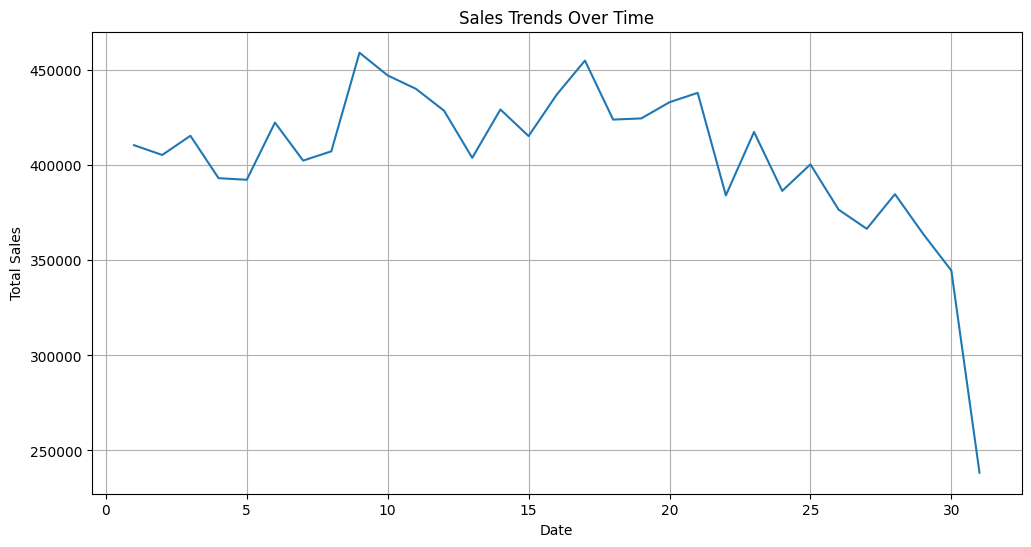

In [20]:
# Group by PurchaseDate and sum the TotalAmount
sales_trends = dataset.groupby(dataset["Day"])["TotalAmount"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data = sales_trends, x = "Day", y = "TotalAmount")
plt.title("Sales Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

### 5. Modeling and prediction

There will be 2 models made using the dataset:
- A clustering model using `k-means` algorithm, that will sepearate the customers into different categories.
- A predictive model that will predict the `Total Amount` using `Random Forest` Algorithm.
- A recommendation system to recommend 5 products to a customer.

1. Clustering model

In [21]:
# Importing the KMeans function
from sklearn.cluster import KMeans

In [22]:
# Aggregate data to get total amount spent by each customer
customer_data = dataset.groupby("CustomerID").agg({
    "TotalAmount": "sum",
    "Quantity": "sum"
}).reset_index()

# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[["TotalAmount", "Quantity"]])

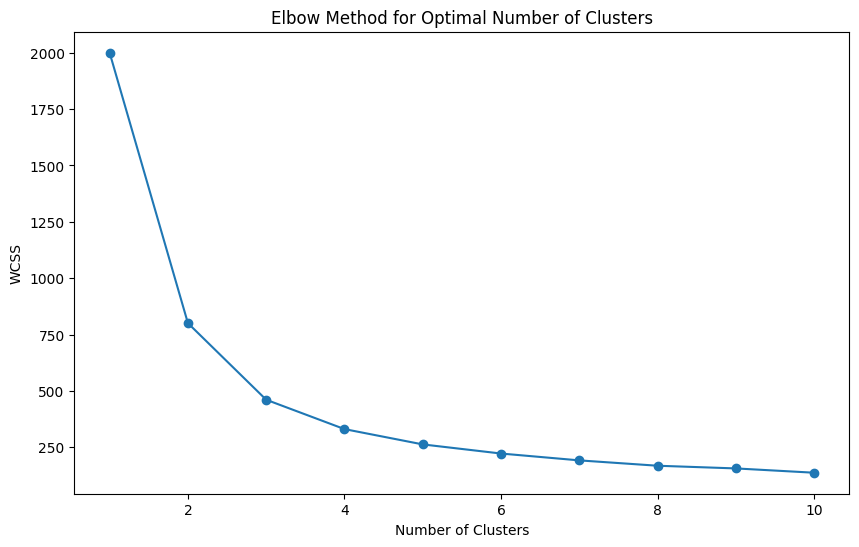

In [23]:
# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize = (10, 6))
plt.plot(range(1, 11), wcss, marker = "o")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

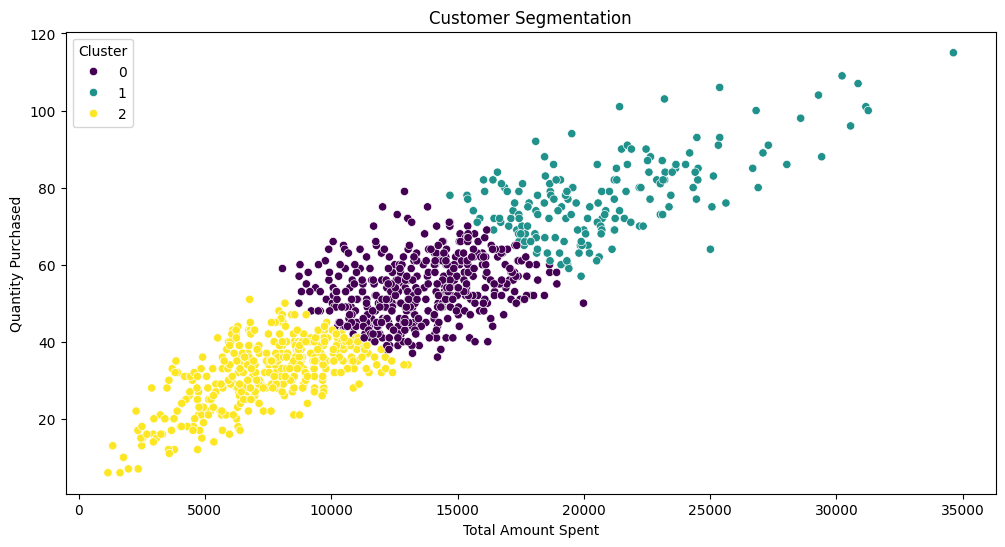

In [24]:
# Train K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters = 3, random_state = 42)
customer_data["Cluster"] = kmeans.fit_predict(scaled_data)

# Visualize the clusters
plt.figure(figsize = (12, 6))
sns.scatterplot(x = "TotalAmount", y = "Quantity", hue = "Cluster", data = customer_data, palette = "viridis")
plt.title("Customer Segmentation")
plt.xlabel("Total Amount Spent")
plt.ylabel("Quantity Purchased")
plt.show()

In [25]:
# We can predict the cluster of the Custom he/she fells into based on the TotalAmount spent and the Quantity of products they bought.
customer_data.head()

,CustomerID,TotalAmount,Quantity,Cluster
0,1,17026.90,70,1
1,2,7928.46,48,2
2,3,14719.17,52,0
3,4,5148.99,25,2
4,5,9319.94,33,2


2. Random Forest Model

In [26]:
from sklearn.model_selection import train_test_split

# Feature and target variable
X = customer_data[["Quantity"]]
y = customer_data["TotalAmount"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


Training set size: 800
Testing set size: 200


In [27]:
from sklearn.ensemble import RandomForestRegressor

# Train the Random Forest regression model
model = RandomForestRegressor(n_estimators = 100, random_state = 42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)


Mean Absolute Error (MAE): 1983.4644070927927
R-squared: 0.7626377641377874


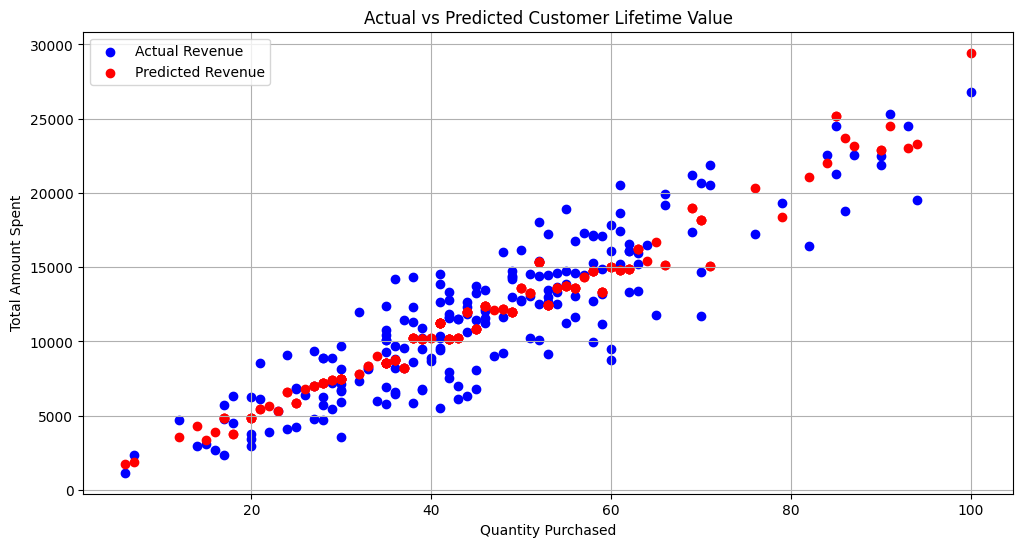

In [28]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate MAE and R-squared
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# Plot the results
plt.figure(figsize = (12, 6))
plt.scatter(X_test, y_test, color = "blue", label = "Actual Revenue")
plt.scatter(X_test, y_pred, color = "red", label = "Predicted Revenue")
plt.title("Actual vs Predicted Customer Lifetime Value")
plt.xlabel("Quantity Purchased")
plt.ylabel("Total Amount Spent")
plt.legend()
plt.grid(True)
plt.show()


3. Recommendation system

In [29]:
# Required Libraries
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
# Create a pivot table with CustomerID as rows, ProductID as columns, and Quantity as values
pivot_table = dataset.pivot_table(index = "CustomerID", columns = "ProductID", values = "Quantity", fill_value = 0)
pivot_table.head()

ProductID,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
CustomerID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,5.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Compute cosine similarity between customers
customer_similarity = cosine_similarity(pivot_table)

In [32]:
# Function to recommend products
def recommend_products(customer_id, num_recommendations = 5):

    # Taking the index value of the customer
    customer_idx = pivot_table.index.get_loc(customer_id)
    
    # Getting the similarity score of the customer with the different customers
    similarity_scores = list(enumerate(customer_similarity[customer_idx]))

    # Sorting the similarities with greatest to lowest
    similarity_scores = sorted(similarity_scores, key = lambda x: x[1], reverse = True)

    # Getting the names of the top 10 customers with the greatest similarity
    similar_customers = [pivot_table.index[i[0]] for i in similarity_scores[1 : num_recommendations + 11]]
    
    # Adding the number of purchases made by those 5 customers by the OrderID and sorting it in descending order
    recommended_products = pivot_table.loc[similar_customers].sum(axis = 0).sort_values(ascending = False).head(num_recommendations)
    return recommended_products.index.tolist()

In [33]:
# Example: Recommend products for a specific customer
customer_id = 10
recommendations = recommend_products(customer_id)
print(f'Products recommended for Customer {customer_id}: {recommendations}')

Products recommended for Customer 10: [71, 93, 11, 80, 46]
